# Introduction to Computer Vision - Jacob Bigham
## 3. Image Annotations, Correlation Filtering, Template Matching
We saw in the previous notebook how to apply some basic filters to images to add blur and to remove noise. Here, we expand and improve on those approaches by introducing correlation filtering, which dramatically increases the speed and flexibility of the filters we can apply.

This notebook explores the following:

1. Drawing on Images
2. Correlation Filtering
3. Template Matching and Pattern Recognition

We'll import the usual packages and our `show` functions:

In [1]:
import cv2 as cv
import numpy as np
from cv_utils import show, show_sbs

### 3.1 Image Annotation
We're making great pace, and by the end of this notebook, we'll implement a (very) basic face detection algorithm. Before we jump into the math skills we'll need to do that, we need to add one more more OpenCV skill to our toolbox: annotations. In particular, we want to be able to draw rectangles around areas of interest in an image. Fortunately, OpenCV makes this very easy to do (though, at this point, you should be able to do this using NumPy).

>Use OpenCV's `rectangle` function to draw a rectangle over a given area in an image.

You should review the [documentation](https://docs.opencv.org/master/d6/d6e/group__imgproc__draw.html#ga07d2f74cadcf8e305e810ce8eed13bc9) for the function. Notice that the parameters are the image, the top left coordinate of the rectangle, the bottom right coordinate of the rectaengle, and the color (and optionally the thikness and line type).

Let's add a red rectangle to a photo:

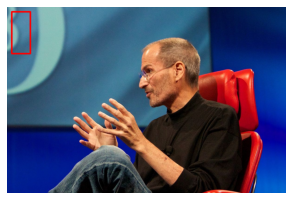

In [2]:
steve = cv.imread('img/steve_jobs.jpg')
steve_rect = cv.rectangle(steve, (20, 20), (100, 200), (0, 0, 255), 5)
show(steve_rect)

Notice that, as usual, our color scheme for the rectangle is BGR. However, **the coordinates for the corners of the rectangle are, *not as usual*, (x, y)**.

What happens if we try to draw a rectangle that would go off the edge of the image?

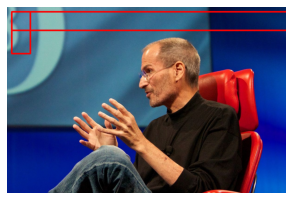

In [3]:
steve_rect_2 = cv.rectangle(steve, (20, 20), (6000, 100), (0, 0, 255), 5)
show(steve_rect_2)

We note first that attempting to draw a rectangle that extends beyond the image does not cause an error. Instead, the rectangle is just clipped at the image boundary. Second, notice that **calling the `rectangle` function on an image *changes the image itself***. This is relatively rare in Python, but those of you familiar with C++ know this is common. Indeed, the function heading for the C++ equivalent of this function would be something like

    cv::rectangle(Image& image, const Point& p1, const Point& p2, const Color& color, int thickness = 1)

(It's actually a little different because of the data structures OpenCV uses under the hood, but this illustrates the point.)

Or, for those of you who use Pandas, this is similar to calling a function with inplace=True. If these things mean absolutely nothing to you, then ignore them. Just be aware that this particular function changes the image when you use it. So, if we wanted to preserve our original image, then we'd need to do something like this:

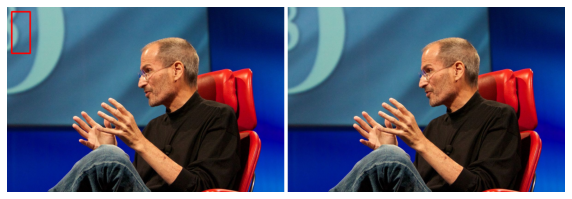

In [4]:
steve = cv.imread('img/steve_jobs.jpg')
steve_rect = cv.rectangle(np.copy(steve), (20, 20), (100, 200), (0, 0, 255), 5)  #notice np.copy(steve)
show_sbs((steve_rect, steve))

Notice that if we wanted to draw a rectangle *around* a point, we'd need to a bit of algebra. In our photo, Steve Jobs's head is centered at roughly (700, 300). Let's draw a square of width 350 around him:

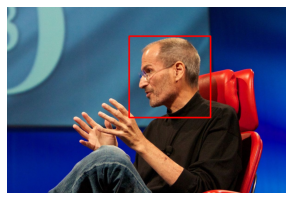

In [5]:
center_x, center_y = 700, 300
width = 350
half_width = width // 2  #image locations need to be integers
top_left = center_x - half_width, center_y - half_width
bottom_right = center_x + half_width, center_y + half_width
steve_head = cv.rectangle(np.copy(steve), top_left, bottom_right, (0, 0, 255), 5)
show(steve_head)

Because we are often going want to draw rectangles around areas in an image where we know the center and width of the box we want to draw (if, for example, we are looking for faces, we will typically find the center of the face), let's write ourselves a function to save having to do the halving calculations every time:

In [6]:
def draw_rect_center(image, center, height, width, color, thickness=1):
    """
    Draws on an image a rectangle centered at 'center' with the given height, width, color, and thickness.
    Modifies the input image.
    Returns the modifies image.
    """
    h_height = height // 2
    h_width = width // 2
    x, y = center
    p1 = x - h_width, y - h_height
    p2 = x + h_width, y + h_height
    cv.rectangle(image, p1, p2, color, thickness)
    return image

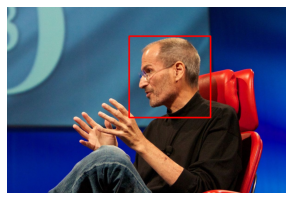

In [7]:
steve_head_2 = draw_rect_center(np.copy(steve), (700, 300), 350, 350, (0, 0, 255), 5)
show(steve_head_2)

Let's make our lives even easier by not typing out color codes every time we want to use a simple color:

In [8]:
COLOR = {
    'red' : (0, 0, 255),
    'orange' : (0, 164, 246),
    'yellow' : (4, 231, 255),
    'green' : (0, 232, 70),
    'blue' : (233, 86, 0),
    'purple' : (233, 0, 39),
    'white' : (255, 255, 255),
    'black' : (0, 0, 0)
}

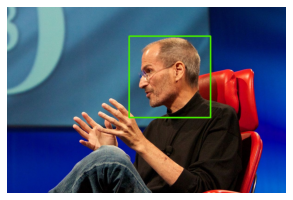

In [9]:
steve_head_2 = draw_rect_center(np.copy(steve), (700, 300), 350, 350, COLOR['green'], 5)
show(steve_head_2)

Both the `draw_rect_center` function and the `COLOR` dictionary will be imported, available, and widely used in future notebooks. When working with most coding packages, it's often necessary to write your own functions and data structures to streamline your code. If this is not habit for you, make it so.

If you want to fill in a rectangle with solid color, pass a negative value to `thickness`:

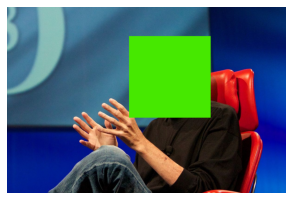

In [10]:
steve_head_3 = draw_rect_center(np.copy(steve), (700, 300), 350, 350, COLOR['green'], -1)
show(steve_head_3)

We can also draw text on an image with OpenCV.

>Use OpenCV's `putText` function to place text over an image.

You should review the [documentation](https://docs.opencv.org/master/d6/d6e/group__imgproc__draw.html#ga5126f47f883d730f633d74f07456c576) for this function as well. Like `rectangle`, the `putText` function **modifies the input image.** To use `putText`, you must specify the image, the text, the location, the font face, the font scale, and the color:

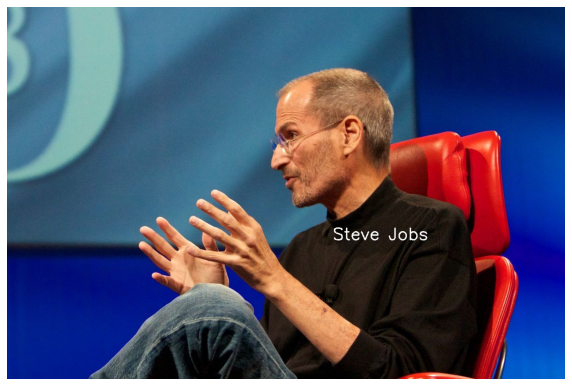

In [11]:
steve_text = cv.putText(steve.copy(), "Steve Jobs", (700, 500), cv.FONT_HERSHEY_SIMPLEX, 1.2, COLOR['white'], thickness=2)
show(steve_text, 10, 10)

Notice that the position for our text specifies the bottom left pixel coordinate. To find the size of the text box, use the `getTextSize` function, which returns a tuple giving the width and height of our label, as well as the y-coordinate of the baseline, which we don't need here.

In [12]:
label = 'Steve Jobs'
scale = 1.2
thickness = 2
(text_width, text_height), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, scale, thickness)
## alternatively: text_width, text_height = cv.getTextSize(...)[0]
print((text_width, text_height))

(207, 26)


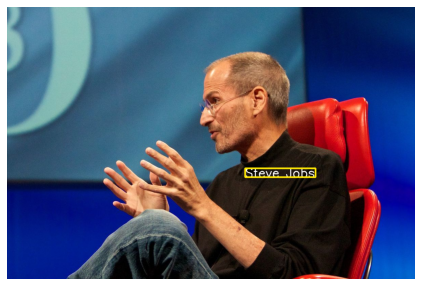

In [13]:
steve_text_2 = cv.putText(steve.copy(), "Steve Jobs", (700, 500), cv.FONT_HERSHEY_SIMPLEX, 1.2, COLOR['white'], thickness=2)
cv.rectangle(steve_text_2, (700, 500 - text_height), (700 + text_width, 500), COLOR['yellow'], thickness=4)
show(steve_text_2, 10)

Notice that elements drawn on an image will be stacked on top of elements drawn before it. If you want text on top of a box, for example, draw the box *and then* the text.

Often, we will want to draw a label below a bounding box. Let's write a function that will do this for us:

In [14]:
def draw_rect_label(image, center, r_height, r_width, r_color, r_thickness, text, text_scale, text_color, text_thickness):
    """
    Draws on an image a rectangle with the given center, size (r_height, r_width), color, and thickness.
    Adds a label centered below the rectangle.
    Not recommended for small boxes or long labels
    Modifies the input image.
    Returns the modifies image.
    """
    image = draw_rect_center(image, center, r_height, r_width, r_color, r_thickness)
    x, y = center
    text_width, text_height = cv.getTextSize(text, cv.FONT_HERSHEY_SIMPLEX, text_scale, text_thickness)[0]
    TEXT_IMAGE_VERTICAL_OFFSET = 5
    text_ori = x - (text_width // 2), y + (r_height // 2) + text_height + TEXT_IMAGE_VERTICAL_OFFSET
    image = cv.putText(image, text, text_ori, cv.FONT_HERSHEY_SIMPLEX, text_scale, text_color, text_thickness)
    return image

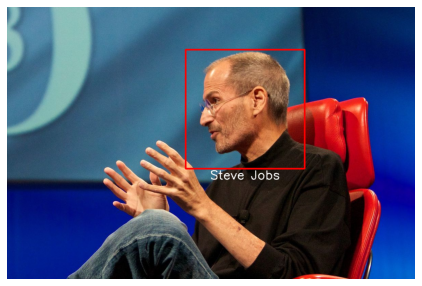

In [15]:
steve_text_3 = draw_rect_label(np.copy(steve), (700, 300), 350, 350, COLOR['red'], 4, "Steve Jobs", 1.2, COLOR['white'], 2)
show(steve_text_3, 10)

That's a lot of parameters, but we're going to get a lot of reuse from this function!

**Summary**
1. Use OpenCV's `rectangle` function to draw a rectangle over a given area.
2. Use OpenCV's `putText` function to place text over an image.

**Exercises**
1. Write your own function, `draw_rect(img, topLeft, bottomRight, color, thickness)`, that draws a rectangle on the image `img`, where `topLeft` is a tuple containing the (x, y) coordinate of the top left pixel of the rectangle, `bottomRight` is that of the bottom right pixel of the rectangle, `color` is a 3-tuple containing the BGR components of the color, and `thickness` is the pixel width of the rectangle. Obviously, do not use OpenCV's `rectangle` function (or any other image package's annotation functions) to accomplish this.

**Exercise 1:** There are certainly many ways to do this, but what comes to mind for me is to create a mask that contains only 1s along the rectangle you want to create, and then set the corresponding pixels in the image to the color:

In [16]:
def draw_rect(img, topLeft, bottomRight, color, thickness):
    """
    Draws a rectangle on an image specified by the params.
    Returns the modified image in BGR.
    """
    if len(img.shape) == 2:
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    height, width, _ = img.shape
    mask = np.zeros((height, width), dtype=bool)
    x1, y1 = topLeft
    x2, y2 = bottomRight
    mask[y1:y2, x1:x2] = 255  # in NumPy, (y, x)
    mask[y1 + thickness : y2 - thickness, x1 + thickness : x2 - thickness] = 0
    color = np.asarray(color)
    img[mask] = color
    return img

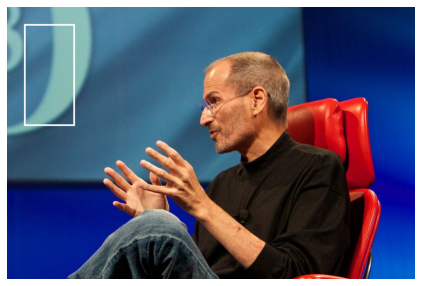

In [17]:
steve_rect_4 = draw_rect(steve.copy(), (50, 50), (200, 350), COLOR['white'], 5)
show(steve_rect_4, 10)

### 3.2 Correlation Filtering
As a general note, moving forward we're going to encounter a decent bit of math, some of which can get decently complicated. My goal in these notebooks is to provide a robust toolbox for image processing. My goal is not to replicate years of mathematics education, and I will often link to good resources without providing too much mathematical theory. When something warrants explanation or clarification, I will give it. Otherwise, if you want to learn more, go out and learn more.

Now we're starting to get to the really fun stuff! We saw in the last notebook that we can apply filters to images to deal with noise and/or to blur the image. Unfortunately, the iterative approach we took we limited in complexity and took far too long to run. We saw that OpenCV has built-in functions that performed the same filtering tasks, and those functions ran nearly instantaneously. Of course, they don't run faster *because* they're built-in; there's still code running behind the scenes. They're built-in because they run faster by using parallelized and vectorized approaches to solving tasks.

One such approach is to use correlation filtering.

***A point of confusion:*** You may have confused before the distinction between correlation and convolution. You may, in fact, be familiar with convolutions from a signal-processing or machine learning perspective. Correlation and convolution do not mean the same thing, but they are often used interchangeably because they often accomplish the same thing. Indeed, in convolutional neural nets, weights are generally learned for a correlation matrix, not for a convolution matrix. As we will see, though, this distinction does not matter for CNNs. **I will call correlation "correlation", even though other sources will refer to it as convolution.**

A correlation filter is basically a mask that we slide over an image (or any data). Consider the following matrix:

$$h=\frac{1}{9}\begin{bmatrix}1 & 1 & 1 \\1 & 1 & 1 \\1 & 1 & 1\end{bmatrix}$$

Let's say we took this and stamped it on top of every 3x3 block in an image and multiplied element-wise. We'd be computing the average value for each block in the image. *This is functionally equivalent to the iterative approach we took in the previous notebook.* The matrix of weights that we "stamp" onto the image is called a **kernel**.

I highly recommend watching [this video](https://youtu.be/5xdbJ7z4Nrc?list=PLjMXczUzEYcHvw5YYSU92WrY8IwhTuq7p&t=2116) for a great overview of how this works and some examples of common filters. Indeed, don't move forward without watching it.

>We can apply a kernel to an image using OpenCV's `filter2D` function.

For example, if we use $h$ from above, we lightly blur an image:

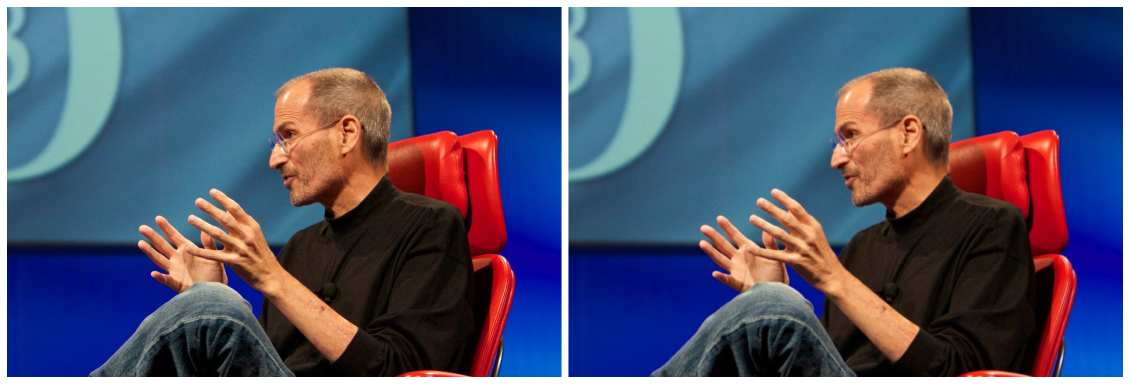

In [18]:
kernel = np.full((3,3), 1/9)
blurry_steve = cv.filter2D(steve, -1, kernel)
show_sbs((steve, blurry_steve), show_width=20)

(The -1 parameter just means to keep the same depth in the output image as in our input image.)

The difference here is not dramatic. What happens if we use a much larger kernel?

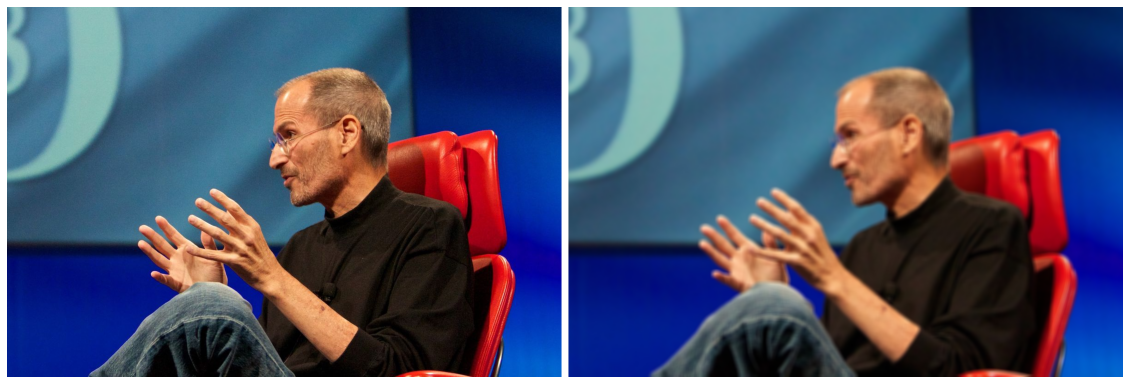

In [19]:
kernel = np.full((11,11), 1/121) #What happens if you forget to change the 1/9? Try it out.
blurrier_steve = cv.filter2D(steve, -1, kernel)
show_sbs((steve, blurrier_steve), show_width=20)

Now it's pretty obvious that the filter is blurring the image. (We use "kernel" and "filter" more or less interchangeably.) What we did here is the same as using OpenCV's built-in `blur` function, as we did in the last notebook.

Notice that, as we did with the iterative approach, we still run into issues at the edges of an image. For the most part, we won't need to worry about what to do there, but I'll point out any instances in which we need to employ a specific approach to processing the edges of an image.

You should familiarize yourself with the output from common filters. Here's a [good introduction](https://www.youtube.com/watch?v=OfAB7K8CRDQ) to some basic ones.

What do the following filters do?

$a=\begin{bmatrix}1 & 0 \\0 &-1\end{bmatrix}$

$b=\begin{bmatrix}1 & -1\end{bmatrix}$

(Notice the dimensions do not have to be odd, though they make more intuitive sense when they are.)

The first one will result in higher values when the difference between the upper left and bottom right pixels is high. This would detect diagonal boundaries. The second would, similarly, detect horizontal boundaries. Let's apply these to a grayscaled Steve Jobs:

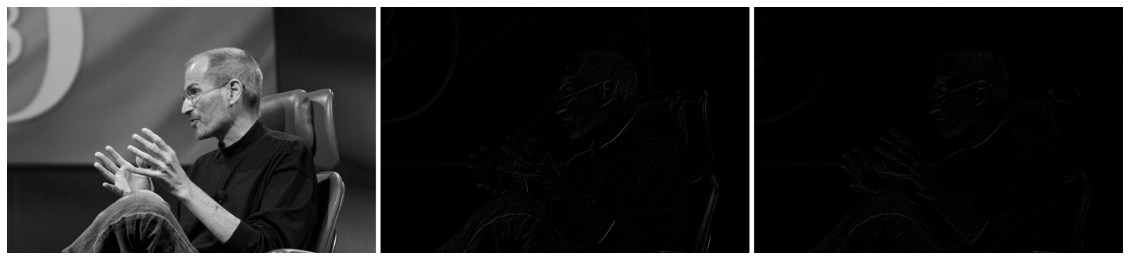

In [20]:
gray_steve = cv.cvtColor(steve, cv.COLOR_BGR2GRAY)
a = np.array([[1, 0], [0, -1]])
b = np.array([1, -1])
steve_a = cv.filter2D(gray_steve, -1, a)
steve_b = cv.filter2D(gray_steve, -1, b)
show_sbs((gray_steve, steve_a, steve_b), show_width=20)

You have to look *really* close to see which pixels are highly activating the filter here. Let's use thresholding to up the contrast:

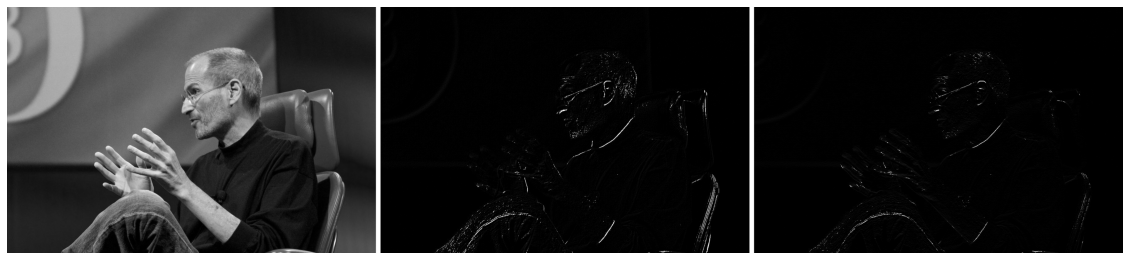

In [21]:
steve_a[steve_a > 30] = 255
steve_b[steve_b > 30] = 255
show_sbs((gray_steve, steve_a, steve_b), show_width=20)

The output here looks similar to the output of our basic edge detector from the first notebook. 

Basically, a correlation filter replaces each pixel with the degree to which its surroundings match the pattern in the kernel. So, what would this kernel do?

$h=\begin{bmatrix}0 & -1 & 1 \\-1 & 5 & -1 \\0 & -1 & 0\end{bmatrix}$

This would sharpen an image! One of the assumptions we made before is that neighboring pixels are more likely to resemble each other. Indeed, when we blur, we set each pixel to be some average of the pixels surrounding it. Sharpening is the reverse: we subtract the pixels around a central pixel.

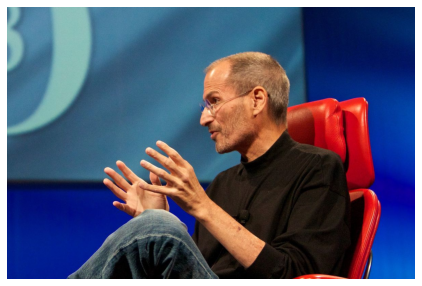

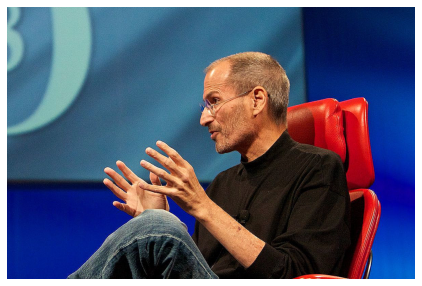

In [22]:
sharp_mask = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharp_steve = cv.filter2D(steve, -1, sharp_mask)
show(steve, 20)
show(sharp_steve, 20)

In the sharpened photo, smaller details should stand out to you. We have essentially accentuated the differences between neighboring pixels.

Perhaps the most common kernel is the gaussian, which weights the central and surrounding pixels based on a normal distribution.

For example, a 5x5 gaussian kernel looks something like this, depending on the standard deviation:

$$\frac{1}{256}\begin{bmatrix}1&4&6&4&1\\4&16&24&16&4\\6&24&36&24&6\\4&16&24&16&4\\1&4&6&4&1\end{bmatrix}$$

Notice that it is circularly symmetric.

Don't create your own gaussians. In OpenCV, use the function `getGaussianKernel` to create a gaussian kernel with a given width and standard deviation. To apply a guassian blur, use the OpenCV function `GaussianBlur` (note the capitalization).

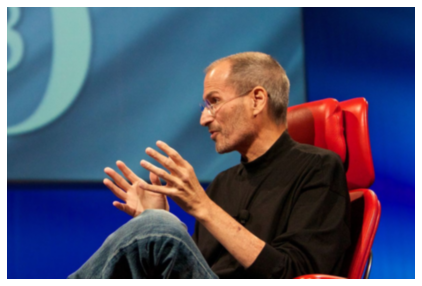

In [23]:
gauss_steve = cv.GaussianBlur(steve, (5, 5), 5)
show(gauss_steve, 20)

Notice that in each of our filters, the weights sum to 1 (i.e., they are *normalized*). That way, we should not (for the most part) exceed the maximum value (for us right now, 255) for any given pixel intensity.

There are many filters that accomplish many different things. We will encounter them as-needed, so I will not try to introduce anywhere near the full scope of useful kernels. For now, what you need to know is that we can create our own kernels, and the correlation process is extremely rapid.

**Summary**
1. Correlation filters (often referred to as convolutions) allow us to speed up our application of masks to images.
2. After we apply the correlation (often said as "after we convolve the image"), the resulting image has higher values where the pattern in the image matches the pattern in the correlation kernel.
3. Correlation is orders of magnitude faster than the iterative approach to filtering that we took in the previous notebook.

**Exercises**
1. An extreme version of correlation "filtering" would be to take the sum of the elementwise product of two equal-sized images. One possible use for this is to find the similarity between two images. The higher the sum of the elementwise product, the more similar the images. (This isn't generally a good way to compute the similarity between images; consider the any image will be maximally "similar" to a blank white image.) Consider the following three images, each of which was taken with a separate light filter such that the first is the blue intensity, the second is the green intensity, and the third is the red intensity:<br>
<img src="img/t1.jpg" width="250px" style="display:inline">  <img src="img/t2.jpg" width="250px" style="display:inline">  <img src="img/t3.jpg" width="250px" style="display:inline"><br><br>
Read in each of these images (`img/t1.jpg`, `img/t2.jpg`, and `img/t3.jpg`, respectively) and align them so that the cross-correlation between each of the channels is maximal. Save the resulting color image as `img/aligned.jpg`. It might help to first process each channel with an edge-detection filter, since the intensities for each color channel do not vary uniformly. (This is adapted from [this assignment](https://web.eecs.umich.edu/~justincj/teaching/eecs442/hw1.html) from Justin Johnson's computer vision course at the University of Michigan.)

**Exercise 1:** Let's keep the first image, which represents the red channel, fixed. We can use NumPy's `roll` function to shift the second images horizontally to try and align them with the first. (The `roll` function wraps around, which menas we don't penalize shifting as much as we would if the pixels were simply lost past the edges.) The images are pretty nearly aligned as it is, so let's try values between -20 and 20 for the x and y shifts.

Because the color intensities are quite different in each channel, let's first run a basic edge detection 

Let's see what the unaligned combination of the three images looks like:

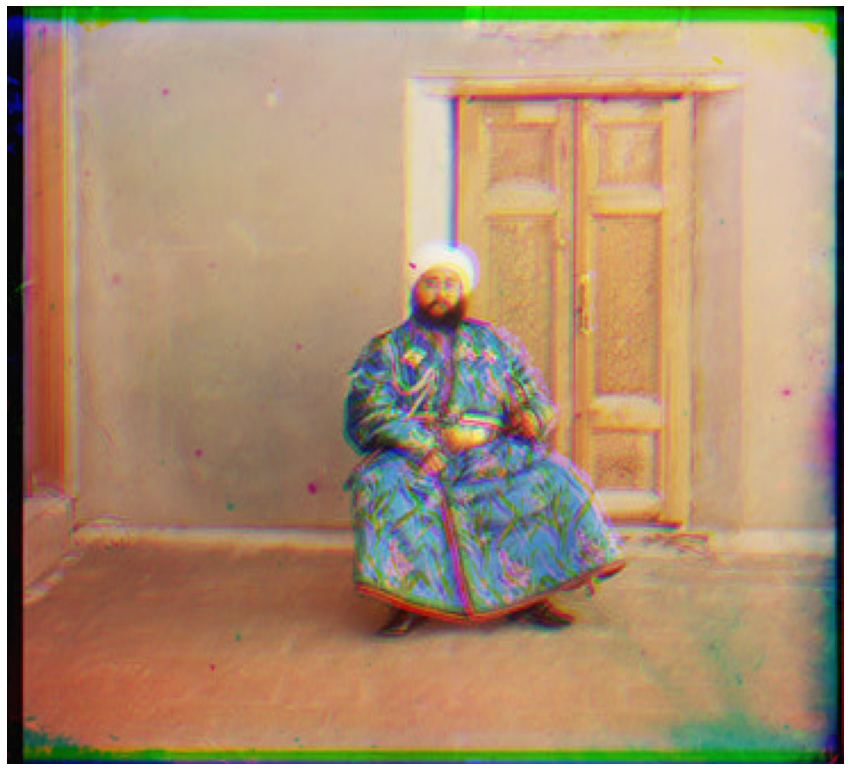

In [24]:
t1 = cv.imread('img/t1.jpg')
t1 = cv.cvtColor(t1, cv.COLOR_BGR2GRAY)
t2 = cv.imread('img/t2.jpg')
t2 = cv.cvtColor(t2, cv.COLOR_BGR2GRAY)
t3 = cv.imread('img/t3.jpg')
t3 = cv.cvtColor(t3, cv.COLOR_BGR2GRAY)
original = cv.merge([t1, t2, t3])
show(original, 15, 15)

We have to iteratively check each (x, y) transformation to see which yields the greatest cross-correlation. Notice that most of the data is contained within the 250x250 central area:

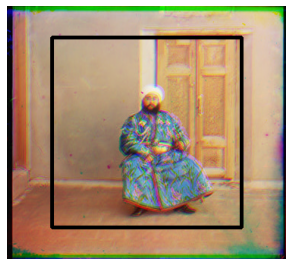

In [25]:
height, width, _ = original.shape
center = width // 2, height // 2
original_box = draw_rect_center(np.copy(original), center, 250, 250, COLOR['black'], thickness=4)
show(original_box)

So, we can save a bit on the processing time (and diminish the impact of the rough image quality at the edges) by just considering that box within the image. Let's run an edge-detection filter on each channel as well:

In [26]:
trimmed = original[center[0] - 125 : center[0] + 125 + 1, center[1] - 125 : center[1] + 125 + 1]
b, g, r = cv.split(trimmed)
b = (cv.filter2D(b, -1, a) > 40) * 255  #a from above: [[1, 0], [0, -1]]
g = (cv.filter2D(g, -1, a) > 40) * 255
r = (cv.filter2D(r, -1, a) > 40) * 255

Now we can can run our cross-correlation on the edges:

Green shift: x(3), y(-2)
Red shift: x(4), y(-4)


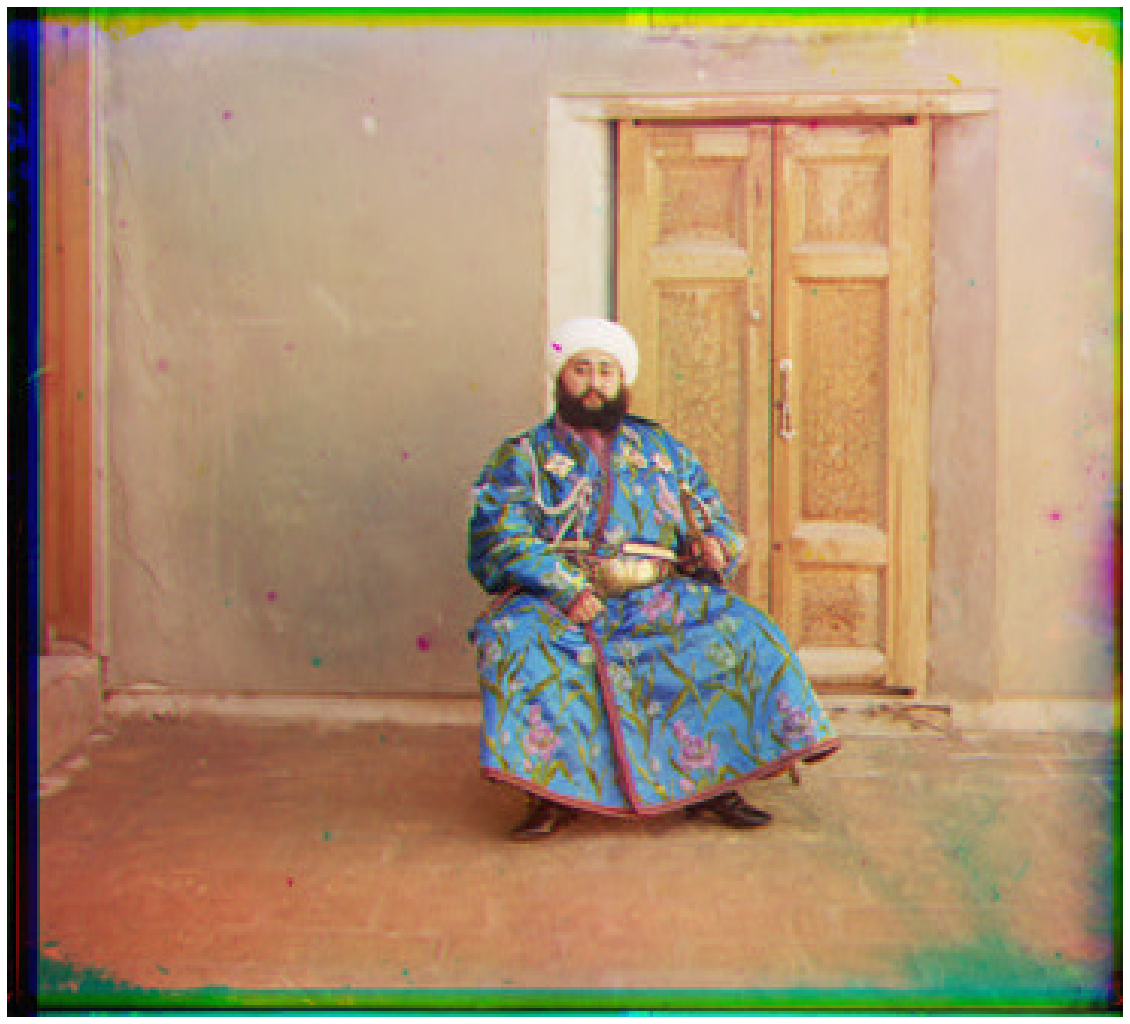

In [27]:
x_g, y_g = (0, 0)
max_corr_g = 0
x_r, y_r = (0, 0)
max_corr_r = 0
for x in range(-15, 15):
    for y in range(-15, 15):
        g_trans = np.roll(g, (y, x), (0, 1))
        corr_g = np.sum(b * g_trans)
        if corr_g > max_corr_g:
            max_corr_g = corr_g
            x_g, y_g = x, y
        
        r_trans = np.roll(r, (y, x), (0, 1))
        corr_r = np.sum(b * r_trans)
        if corr_r > max_corr_r:
            max_corr_r = corr_r
            x_r, y_r = x, y
b, g, r = cv.split(original)
g = np.roll(g, (y_g, x_g), (0, 1))
r = np.roll(r, (y_r, x_r), (0, 1))
aligned = cv.merge([b, g, r])
cv.imwrite('img/aligned.jpg', aligned)
print("Green shift: x({}), y({})".format(x_g, y_g))
print("Red shift: x({}), y({})".format(x_r, y_r))
show(aligned, 20, 20)

You don't *have* to use edge detection before correlating the images (or, as an alternative strategy, taking the sum of squared differences between pixels), but it sure makes the result more reliable. Indeed, much of the important information in an image is contained in its edges. Particularly when trying to align, do we care about maximizing overlap between pixel intensities in random color regions, or do we care about maximizing overlap between edges? (The latter.)

**In general**, you will want to do some amount of processing/filtering before trying to analyze the data in an image. This [video](https://www.youtube.com/watch?v=LkkHdb7fgIQ) gives a good example of why that is the case. (You will be safe ignoring the discussion about linear operators and just taking away that because image data is rarely nice and perfectly smooth, it helps to filter first to find edges.)

### 3.2 Template Matching and Pattern Recognition
What we did in the image alignment exercise was an extreme version of **template matching**. Namely, we used one of the color channels as a template and matched (found the maximum similarity between) the other to channels to it.

We said earlier that the cross-correlation between a filter and a region of an image gives, in general, a good indication of the degree of similarity between them. So, one way simple to try to find entities in an image is to correlate our image with a kernel that represents the thing we want to find.

Let's work through an example of this: face detection. First, let's use an image with a few faces:

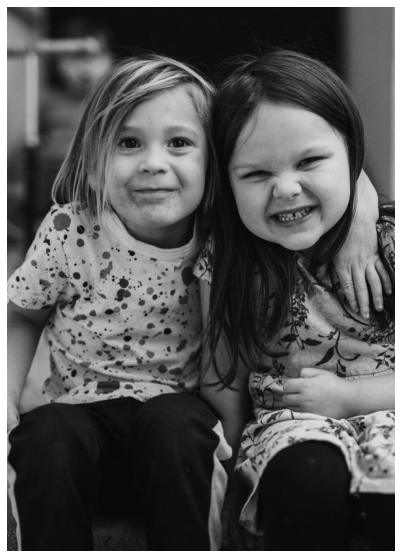

In [28]:
kids = cv.imread('img/kids.jpg')
kids = cv.cvtColor(kids, cv.COLOR_BGR2GRAY)
show(kids, 10, 10)

And let's load a photo with a face, which we'll convert to a normalized kernel. Despite the display size, I have cropped and scaled the face image so that it is roughly the same size as the faces in the photo of the young kids.

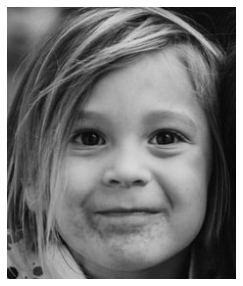

In [29]:
face = cv.imread('img/face.jpg')
face = cv.cvtColor(face, cv.COLOR_BGR2GRAY)
show(face)

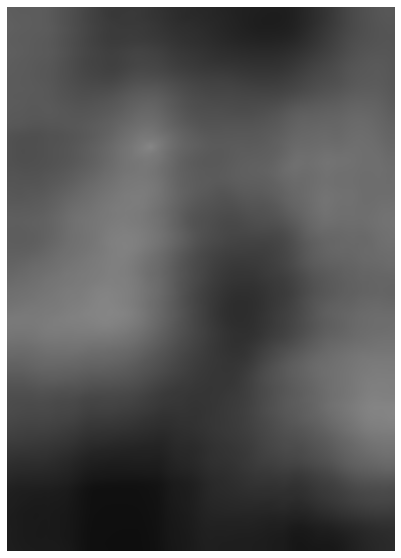

In [30]:
blur_face = face  # cv.GaussianBlur(face, (3,3), 0)
blur_kids = kids  #cv.GaussianBlur(kids, (3,3), 0)
kernel = blur_face / np.sum(blur_face)
correlation_map = cv.filter2D(blur_kids, -1, kernel).astype(np.uint8) 
show(correlation_map, 10, 10)

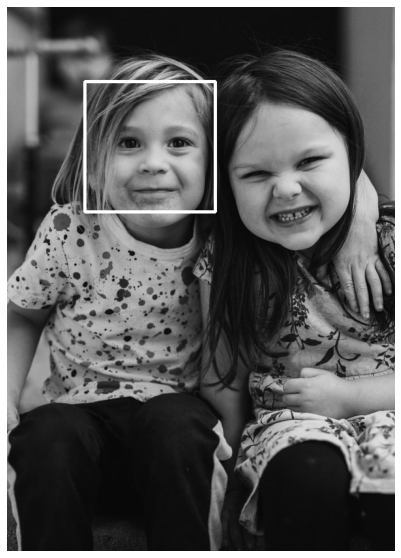

In [31]:
y, x = np.unravel_index(np.argmax(correlation_map), correlation_map.shape)
center = (x, y)
detected_face = draw_rect_center(np.copy(kids), center, 200, 200, COLOR['white'], thickness=3)
show(detected_face, 10, 10)

This is an extremely limited example, but it introduces us to the basic idea of detection in an image. 

Here are some of the limitations: 
1. We are only likely to locate the exact face taken from this image. You'll notice there is no bright spot at the location of the other child's face. Indeed, even slight changes to the image or the filter might corrupt our ability to locate the template in the image.
2. If there are bright/white portions in the image, then those will appear as maximums, even though they would have a high correlation with *any* filter/kernel.

Facial recognition is an extremely rich field, and, as you might imagine, the prevailing strategies for detecting faces in images are much more complex than simple correlation filtering. That said, it's an important first step toward many of the more complicated methods we will learn in the future.

In particular, if the template is large relative to the image you're searching, then your odds are better. So too does this method work well if there isn't a lot of white space in the image you're searching.

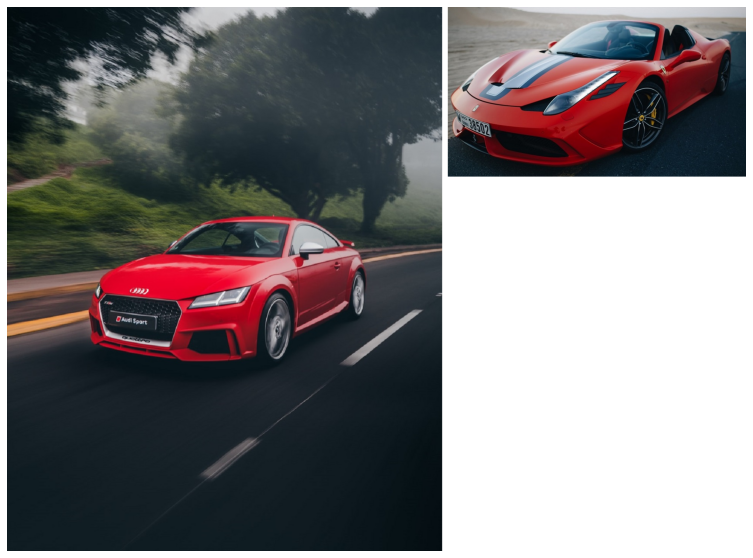

In [32]:
scene = cv.imread('img/car1.jpg')
car = cv.imread('img/car2.jpg')
show_sbs((scene, car), show_width=15)

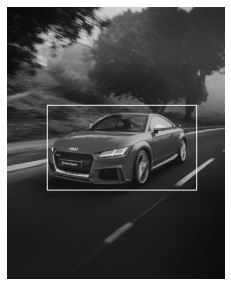

In [33]:
height, width, _ = car.shape#car_red.shape
kernel = car.astype(np.float32) / np.sum(car)
correlation_map_car = cv.filter2D(scene, -1, kernel)
y, x, _ = np.unravel_index(np.argmax(correlation_map_car), correlation_map_car.shape)
center = (x, y)
gray_scene = cv.cvtColor(scene, cv.COLOR_BGR2GRAY)
detected_car = draw_rect_center(np.copy(gray_scene), center, height, width, COLOR['white'], thickness=3)
show(detected_car)

That we were able to box the car is cool, but it's also a relatively bright area of the image, since the surroundings are mostly dark. I cannot repeat enough that we will need to develop far better methods for finding objects.

**Summary**
1. Correlating an image with a particular pattern will reveal regions of the image that express that pattern.
2. We can use this to find specific elements within an image.
3. Generally, this does not allow us to detect objects in an image very well.

**Exercises**

1. This question isn't about object recognition or pattern matching; instead, I want you to start thinking about the arbitrariness of some of the systems we use to represent and understand image data. In the next notebook, we will start to discuss some different ways of representing the position of values in an image (think back to polar and cylindrical coordinates from math). For this exercise, I'd like you to think about how using different color spaces can be useful. Write a function called `rainbowfy` that takes an image and recolors it so that it appears as a rainbow gradient like this:
<img src="img/rainbow_steve.jpg">
You are allowed one NumPy operation. Otherwise, only use the OpenCV library. You should not attempt to work with the image in RGB or BGR space. I have provided a rainbow image. You might find the OpenCV function [`resize`](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d) useful.

**Exercise 1:** The easiest way to approach this problem is to convert to [HSV space](https://en.wikipedia.org/wiki/HSL_and_HSV) and set the H layer equal to the H layer of the rainbow photo, after resizing.

In [34]:
def rainbowfy(image, rainbow_source='img/rainbow.jpg'):
    """
    Adds a rainbow gradient to a BGR image.
    Returns the modified image.
    """
    rainbow = cv.imread(rainbow_source)
    rainbow = cv.cvtColor(rainbow, cv.COLOR_BGR2HSV)
    y, x, _ = image.shape
    rainbow = cv.resize(rainbow, (x, y))
    image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    image[:, :, 0] = rainbow[:, :, 0]
    image = cv.cvtColor(image, cv.COLOR_HSV2BGR)
    return image

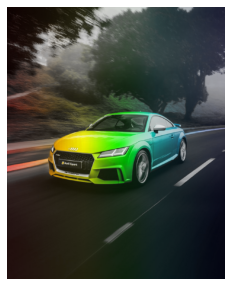

In [35]:
rainbow_car = rainbowfy(scene)
show(rainbow_car)

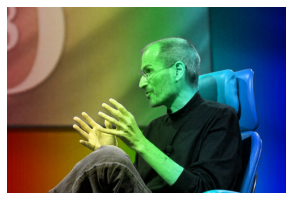

In [36]:
show(rainbowfy(steve))

**Conclusion**

We've once again run into some stumbling blocks. We've upped our ability to apply filters to images, but with that comes a whole new world of complicated problems. That's how we work, though: First, solve simple problems with your simplest tools. Then, improve your tools, which allows you to attack more complex problems, which in turn requires better tools, etc. In the next notebook, we do just that. We'll explore gradients/derivatives in more detail, learn some ways to improve edge detection after using a correlation filter, and dive into a way to detect lines and shapes, which will lay the foundation for the perspective transforms we'll encounter thereafter.